In [1]:
import geopandas as gpd
import json
import numpy as np
from pathlib import Path
from pyproj import CRS
import rasterio
import re
import shapely
from tqdm import tqdm

from tree_detection_framework.detection.region_detections import RegionDetections, reproject_detections
from tree_detection_framework.evaluation.evaluate import match_points, assess_matches

In [2]:
import tree_detection_framework
print(tree_detection_framework.__path__)

['/ofo-share/repos-eric/tree-detection-framework/tree_detection_framework']


# Overview

TODO: Explain

In [3]:
def gdf2rd(gdf):
    return RegionDetections(
        detection_geometries=None, data=gdf, CRS=gdf.crs
    )

In [8]:
PROJECT_ROOT = Path("/ofo-share/species-prediction-project/intermediate/")

# Hand pick these missions to check
CHECK = ["0004", "0005", "0009", "0014"]

# Load field survey data (ground truth)
gt_paths = [
    gpkg_path for gpkg_path in sorted((PROJECT_ROOT / "shifted_field_trees/").glob("*.gpkg"))
    if gpkg_path.name[:4] in CHECK
]
gt_pts = [gdf2rd(gpd.read_file(gpkg_path)) for gpkg_path in gt_paths]

# Load geometric tree detections, aligned with the field survey points
geo_paths = [
    PROJECT_ROOT / "detected_trees" / gpkg_path.stem / "tree_tops.gpkg"
    for gpkg_path in gt_paths
]
geo_pts = [gdf2rd(gpd.read_file(gpkg_path)) for gpkg_path in geo_paths]

# Find the canopy height models, aligned with the field survey points
chm_paths = [
    PROJECT_ROOT / "old_CHMs" / f"{gpkg_path.stem}.tif"
    for gpkg_path in gt_paths
]

# Find the digital surface models, aligned with the field survey points
dtm_paths = [
    PROJECT_ROOT / "photogrammetry" / gpkg_path.stem / "outputs" / f"{gpkg_path.stem}_dtm-ptcloud.tif"
    for gpkg_path in gt_paths
]

# Load orthomosaic tree detections, aligned with the field survey points
# TODO

# Load multi-view tree detections, aligned with the field survey points
# TODO

### CRS Values

What are we working with?

In [9]:
print(f"Field survey:\t{[rd.get_CRS().to_epsg() for rd in gt_pts]}")
print(f"Geo detections:\t{[str(rd.get_CRS()) for rd in geo_pts]}")

chm_crs = []
for path in chm_paths:
    with rasterio.open(path) as src:
        chm_crs.append(str(src.crs))
dtm_crs = []
for path in dtm_paths:
    with rasterio.open(path) as src:
        dtm_crs.append(str(src.crs))
print(f"CHMs:\t\t{chm_crs}")
print(f"DTMs:\t\t{dtm_crs}")

Field survey:	[4326, 4326, 4326, 4326]
Geo detections:	['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']
CHMs:		['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']
DTMs:		['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']


In [10]:
assert len(set(dtm_crs)) == 1
assert all([chm == dtm_crs[0] for chm in chm_crs])

with rasterio.open(dtm_paths[0]) as src:
    matches = re.findall(r'AUTHORITY\["EPSG","(\d+)"\]', src.crs.to_wkt())
    target_crs = CRS.from_epsg(int(matches[-1]))

In [11]:
# Reconfigure the region detections
gt_pts = [
    reproject_detections(rd, target_crs)
    for rd in gt_pts
]

geo_pts = [
    reproject_detections(rd, target_crs)
    for rd in geo_pts
]

In [12]:
# Final check
print(f"Field survey:\t{[str(rd.get_CRS()) for rd in gt_pts]}")
print(f"Geo detections:\t{[str(rd.get_CRS()) for rd in geo_pts]}")

Field survey:	['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']
Geo detections:	['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']


# Matching Points

2025-08-20 15:26:17,349 - INFO - Using height as an additional scaled dimension to compute distance


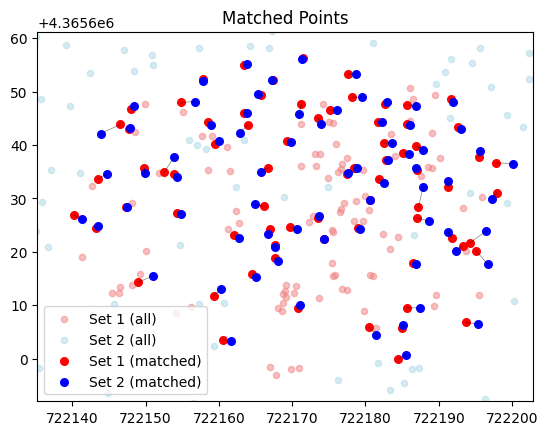

2025-08-20 15:26:17,648 - INFO - Using height as an additional scaled dimension to compute distance


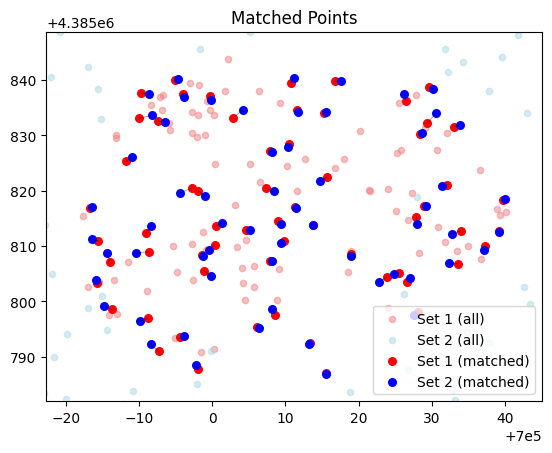

2025-08-20 15:26:17,920 - INFO - Using height as an additional scaled dimension to compute distance


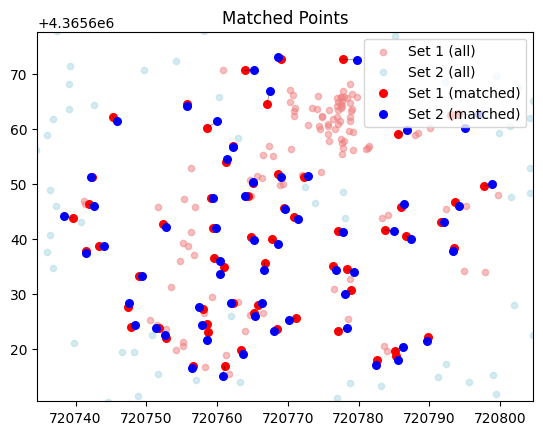

2025-08-20 15:26:18,193 - INFO - Using height as an additional scaled dimension to compute distance


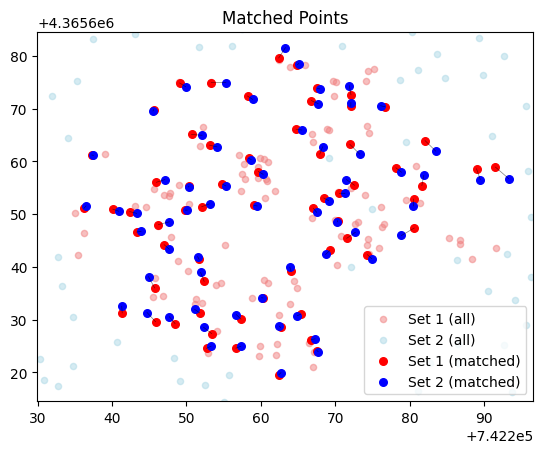

In [33]:
hcol1 = {"height_column_1": "height"}
hcol2 = {"height_column_2": "height"}
# hcol1 = {}
# hcol2 = {}

matches = []
for ptsA, ptsB, chm_path in zip(gt_pts, geo_pts, chm_paths):
    matches.append(
        match_points(
            ptsA,
            ptsB,
            use_height_in_distance=0.1,
            **hcol1,
            **hcol2,
            vis=True,
        )
    )

# Output cylinder info

In [34]:
data = {}
for path, tpath, cpath, rd1, rd2, match_data in zip(tqdm(gt_paths), dtm_paths, chm_paths, gt_pts, geo_pts, matches):
    coords1 = shapely.get_coordinates(rd1.get_data_frame().geometry)
    coords2 = shapely.get_coordinates(rd2.get_data_frame().geometry)
    with rasterio.open(tpath) as dtm:
        dtm1 = np.array(list(dtm.sample(coords1)))
        dtm2 = np.array(list(dtm.sample(coords2)))
    with rasterio.open(cpath) as chm:
        chm1 = np.array(list(chm.sample(coords1)))
        chm2 = np.array(list(chm.sample(coords2)))

    if len(hcol1) == 0:
        height1 = chm1
    else:
        height1 = np.array(rd1.detections["height"]).reshape(-1, 1)
    if len(hcol2) == 0:
        height2 = chm2
    else:
        height2 = np.array(rd2.detections["height"]).reshape(-1, 1)
    
    idx1 = [i1 for i1, _, _ in match_data]
    idx2 = [i2 for _, i2, _ in match_data]
    mask1 = np.zeros(len(coords1), dtype=bool)
    mask2 = np.zeros(len(coords2), dtype=bool)
    mask1[idx1] = True
    mask2[idx2] = True

    data[path.stem] = {
        "matched": {
            "pts1": {
                "starts": np.hstack([coords1[idx1], dtm1[idx1]]).tolist(),
                "ends": np.hstack([coords1[idx1], dtm1[idx1] + height1[idx1]]).tolist(),
            },
            "pts2": {
                "starts": np.hstack([coords2[idx2], dtm2[idx2]]).tolist(),
                "ends": np.hstack([coords2[idx2], dtm2[idx2] + height2[idx2]]).tolist(),
            },
            "between": {
                "starts": np.hstack([coords1[idx1], dtm1[idx1] + height1[idx1]]).tolist(),
                "ends": np.hstack([coords2[idx2], dtm2[idx2] + height2[idx2]]).tolist(),
            }
        },
        "unmatched": {
            "pts1": {
                "starts": np.hstack([coords1[~mask1], dtm1[~mask1]]).tolist(),
                "ends": np.hstack([coords1[~mask1], dtm1[~mask1] + height1[~mask1]]).tolist(),
            },
            "pts2": {
                "starts": np.hstack([coords2[~mask2], dtm2[~mask2]]).tolist(),
                "ends": np.hstack([coords2[~mask2], dtm2[~mask2] + height2[~mask2]]).tolist(),
            },
        },
    }

100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


In [35]:
SAVE = Path("/ofo-share/scratch-eric/evaluate_matches/")
json.dump(data, (SAVE / "GTvsGEO_w-height_hthresh-0.5x_dthresh-0.1xp1_dist-0.1.json").open("w"))